In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

print("--- Loading New Dataset (GSE100736) ---")
try:
    file_path = 'GSE100736_series_matrix.txt'
    
    data_starts_at = 0
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.startswith('!series_matrix_table_begin'):
                data_starts_at = i + 1
                break

    df_new = pd.read_csv(file_path, sep='\t', skiprows=data_starts_at)
    
    df_new.rename(columns={'ID_REF': 'GeneSymbol'}, inplace=True)
    
    print("\nNew data loaded successfully.")
    print("Data Preview:")
    display(df_new.head())
    
    print("\nColumn Information:")
    df_new.info()

except FileNotFoundError:
    print(f"\nError: Could not find the file '{file_path}'. Please ensure it has been unzipped and is in the same folder as your notebook.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Loading New Dataset (GSE100736) ---

New data loaded successfully.
Data Preview:


,GeneSymbol,GSM2692159,GSM2692160,GSM2692161,GSM2692162,GSM2692163,GSM2692164
0,PH_hs_0000002,51.941424,50.185623,55.103588,86.783779,69.841698,69.376643
1,PH_hs_0000003,29.730871,30.548970,43.177297,33.806957,56.148810,54.175143
2,PH_hs_0000004,9255.236213,9204.232340,8615.469684,14367.569290,10863.059360,11604.114550
3,PH_hs_0000005,24.855384,28.865828,19.324716,17087.634820,13082.112690,11289.683530
4,PH_hs_0000006,67.651328,71.505418,63.777254,72.067995,63.397986,55.375261



Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54926 entries, 0 to 54925
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GeneSymbol  54926 non-null  object 
 1   GSM2692159  54925 non-null  float64
 2   GSM2692160  54925 non-null  float64
 3   GSM2692161  54925 non-null  float64
 4   GSM2692162  54925 non-null  float64
 5   GSM2692163  54925 non-null  float64
 6   GSM2692164  54925 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.9+ MB


In [3]:
# This assumes 'df_new' is the DataFrame you loaded in the previous cell.

print("--- Starting Analysis of New Dataset (GSE100736) ---")
try:
    # --- Part 1: Run the Analysis ---
    # Define the new sample columns (3 replicates each)
    control_replicates_new = ['GSM2692162', 'GSM2692163', 'GSM2692164']
    resistant_replicates_new = ['GSM2692159', 'GSM2692160', 'GSM2692161']
    
    # Average the new replicates
    df_new['Control_Avg'] = df_new[control_replicates_new].mean(axis=1)
    df_new['Resistant_Avg'] = df_new[resistant_replicates_new].mean(axis=1)

    # Filter for active genes
    filtered_df_new = df_new[(df_new['Control_Avg'] > 1) | (df_new['Resistant_Avg'] > 1)].copy()

    # Calculate p-values and fold change
    stats, p_values = ttest_ind(
        filtered_df_new[control_replicates_new],
        filtered_df_new[resistant_replicates_new],
        axis=1,
        equal_var=False
    )
    filtered_df_new['p_value'] = p_values
    pseudocount = 1
    filtered_df_new['log2FoldChange'] = np.log2((filtered_df_new['Resistant_Avg'] + pseudocount) / (filtered_df_new['Control_Avg'] + pseudocount))
    print("Step 1: Statistical analysis complete.")

    # --- Part 2: Get and Print the New Counts ---
    filtered_df_new['significance'] = 'Not Significant'
    filtered_df_new.loc[(filtered_df_new['log2FoldChange'] > 1) & (filtered_df_new['p_value'] < 0.05), 'significance'] = 'Upregulated'
    filtered_df_new.loc[(filtered_df_new['log2FoldChange'] < -1) & (filtered_df_new['p_value'] < 0.05), 'significance'] = 'Downregulated'

    up_count = len(filtered_df_new[filtered_df_new['significance'] == 'Upregulated'])
    down_count = len(filtered_df_new[filtered_df_new['significance'] == 'Downregulated'])

    print("\n" + "="*40)
    print("       RESULTS FOR NEW DATASET (TMZ)")
    print("="*40)
    print(f"Total Significantly Upregulated Genes: {up_count}")
    print(f"Total Significantly Downregulated Genes: {down_count}")
    print("="*40)

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Starting Analysis of New Dataset (GSE100736) ---
Step 1: Statistical analysis complete.

       RESULTS FOR NEW DATASET (TMZ)
Total Significantly Upregulated Genes: 3185
Total Significantly Downregulated Genes: 7287


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

print("--- Comparing Results from Both Studies ---")

try:
    # --- Part 1: Re-create the Upregulated List from Your First Study (Olaparib) ---
    # This ensures we have the original data loaded for comparison.
    file_path_1 = 'GSE295766_All.FPKM.xls'
    df1 = pd.read_excel(file_path_1, engine='xlrd')
    fpkm_cols1 = ['T1.FPKM', 'T2.FPKM', 'TO1.FPKM', 'TO2.FPKM']
    for col in fpkm_cols1:
        df1[col] = pd.to_numeric(df1[col], errors='coerce').fillna(0)
    
    control_reps1 = ['T1.FPKM', 'T2.FPKM']
    resistant_reps1 = ['TO1.FPKM', 'TO2.FPKM']
    df1['Control_Avg'] = df1[control_reps1].mean(axis=1)
    df1['Resistant_Avg'] = df1[resistant_reps1].mean(axis=1)
    filtered_df1 = df1[(df1['Control_Avg'] > 1) | (df1['Resistant_Avg'] > 1)].copy()
    
    stats1, p_values1 = ttest_ind(filtered_df1[control_reps1], filtered_df1[resistant_reps1], axis=1, equal_var=False)
    filtered_df1['p_value'] = p_values1
    
    pseudocount = 1
    filtered_df1['log2FoldChange'] = np.log2((filtered_df1['Resistant_Avg'] + pseudocount) / (filtered_df1['Control_Avg'] + pseudocount))
    
    olaparib_upregulated_genes = filtered_df1[
        (filtered_df1['log2FoldChange'] > 1) & (filtered_df1['p_value'] < 0.05)
    ]['GeneSymbol'].tolist()
    print("Step 1: Successfully generated gene list from the first study (Olaparib).")

    # --- Part 2: Get the Upregulated List from Your Second Study (TMZ) ---
    # This uses the 'filtered_df_new' variable you already have in memory.
    tmz_upregulated_genes = filtered_df_new[filtered_df_new['significance'] == 'Upregulated']['GeneSymbol'].tolist()
    print("Step 2: Successfully generated gene list from the second study (TMZ).")

    # --- Part 3: Find and Print the Overlap ---
    # Convert the lists to sets to easily find the intersection
    set_olaparib = set(olaparib_upregulated_genes)
    set_tmz = set(tmz_upregulated_genes)
    
    overlapping_genes = list(set_olaparib.intersection(set_tmz))
    print("Step 3: Comparison complete.")

    # --- Final Results ---
    print("\n" + "="*50)
    print("       COMPARATIVE ANALYSIS RESULTS")
    print("="*50)
    print(f"Genes upregulated in Olaparib study: {len(set_olaparib)}")
    print(f"Genes upregulated in TMZ study:      {len(set_tmz)}")
    print(f"Number of overlapping genes:         {len(overlapping_genes)}")
    print("="*50)
    
    if len(overlapping_genes) > 0:
        print("\nHigh-Confidence Core Resistance Genes (Upregulated in Both Studies):")
        for gene in overlapping_genes:
            print(gene)
    else:
        print("\nNo overlapping upregulated genes were found between the two studies.")

except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Comparing Results from Both Studies ---
Step 1: Successfully generated gene list from the first study (Olaparib).
Step 2: Successfully generated gene list from the second study (TMZ).
Step 3: Comparison complete.

       COMPARATIVE ANALYSIS RESULTS
Genes upregulated in Olaparib study: 263
Genes upregulated in TMZ study:      3185
Number of overlapping genes:         0

No overlapping upregulated genes were found between the two studies.


/opt/homebrew/Cellar/jupyterlab/4.4.5/libexec/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:611: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


--- Creating Final Figures for the TMZ Dataset (GSE100736) ---
✅ New volcano plot saved as 'volcano_plot_tmz.png'.


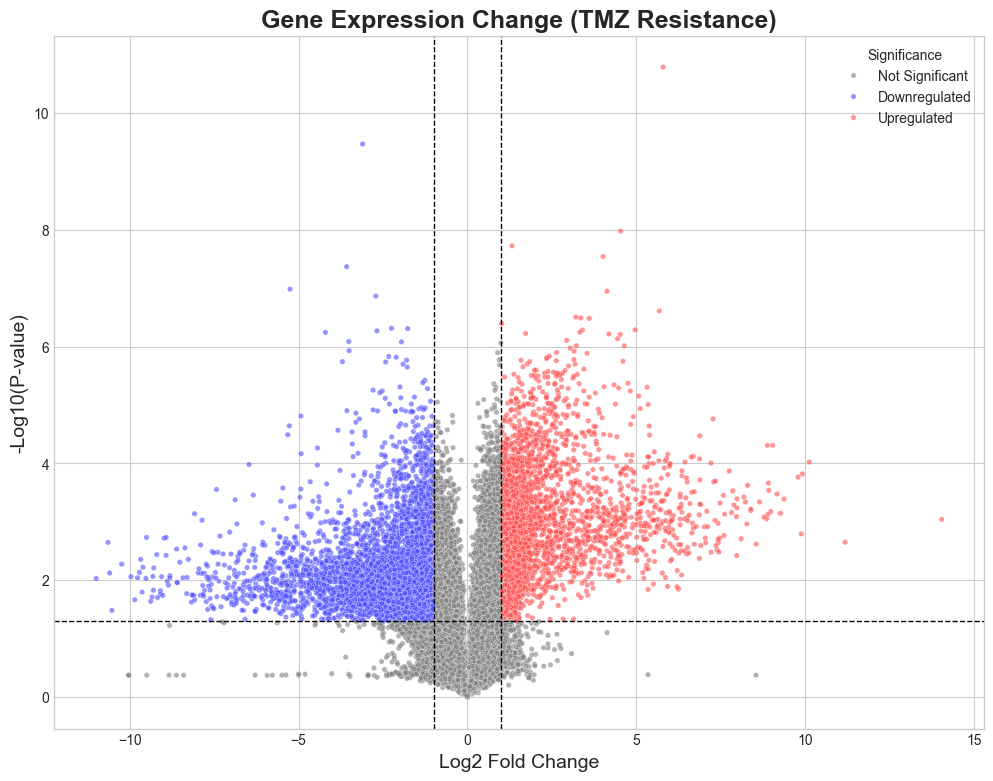

Top 10 upregulated genes table saved as 'top_10_upregulated_tmz.png'.
Top 10 downregulated genes table saved as 'top_10_downregulated_tmz.png'.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("--- Creating Final Figures for the TMZ Dataset (GSE100736) ---")

try:
    # This code assumes 'filtered_df_new' is in memory from your analysis.

    # --- 1. Create and Save the New Volcano Plot ---
    filtered_df_new['-log10_p_value'] = -np.log10(filtered_df_new['p_value'].fillna(1))

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        data=filtered_df_new, x='log2FoldChange', y='-log10_p_value', hue='significance',
        palette={'Upregulated': '#ff4d4d', 'Downregulated': '#4d4dff', 'Not Significant': 'grey'},
        alpha=0.6, s=15
    )
    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-1, color='black', linestyle='--', linewidth=1)
    plt.title('Gene Expression Change (TMZ Resistance)', fontsize=18, weight='bold')
    plt.xlabel('Log2 Fold Change', fontsize=14)
    plt.ylabel('-Log10(P-value)', fontsize=14)
    plt.legend(title='Significance')
    plt.savefig('volcano_plot_tmz.png', dpi=300, bbox_inches='tight')
    print("✅ New volcano plot saved as 'volcano_plot_tmz.png'.")
    plt.show()


    # --- 2. Create and Save the Upregulated Table Image ---
    top_10_up_tmz = filtered_df_new.sort_values(by='log2FoldChange', ascending=False).head(10).round(2)
    fig_up, ax_up = plt.subplots(figsize=(12, 3)) # Adjusted figure size for better fit
    ax_up.axis('tight'); ax_up.axis('off')
    table_up = ax_up.table(cellText=top_10_up_tmz.values, colLabels=top_10_up_tmz.columns, loc='center', cellLoc='center')
    table_up.auto_set_font_size(False); table_up.set_fontsize(8); table_up.scale(1, 1.2)
    plt.savefig('top_10_upregulated_tmz.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
    print("Top 10 upregulated genes table saved as 'top_10_upregulated_tmz.png'.")
    plt.close(fig_up)


    # --- 3. Create and Save the Downregulated Table Image ---
    top_10_down_tmz = filtered_df_new.sort_values(by='log2FoldChange', ascending=True).head(10).round(2)
    fig_down, ax_down = plt.subplots(figsize=(12, 3)) # Adjusted figure size
    ax_down.axis('tight'); ax_down.axis('off')
    table_down = ax_down.table(cellText=top_10_down_tmz.values, colLabels=top_10_down_tmz.columns, loc='center', cellLoc='center')
    table_down.auto_set_font_size(False); table_down.set_fontsize(8); table_down.scale(1, 1.2)
    plt.savefig('top_10_downregulated_tmz.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
    print("Top 10 downregulated genes table saved as 'top_10_downregulated_tmz.png'.")
    plt.close(fig_down)

except NameError:
    print("\nError: 'filtered_df_new' not found. Please re-run the analysis for the new dataset first.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

In [7]:
# This assumes 'filtered_df' is in memory from your previous analysis.

try:
    # Count the occurrences of each category in the 'significance' column
    upregulated_count = len(filtered_df[filtered_df['significance'] == 'Upregulated'])
    downregulated_count = len(filtered_df[filtered_df['significance'] == 'Downregulated'])

    print("--- Final Gene Counts ---")
    print(f"Total Significantly Upregulated Genes: {upregulated_count}")
    print(f"Total Significantly Downregulated Genes: {downregulated_count}")

except NameError:
    print("Error: 'filtered_df' not found. Please run your main analysis cell first.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error: 'filtered_df' not found. Please run your main analysis cell first.


In [9]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

print("--- Running Final Count Verification for TMZ Dataset (GSE100736) ---")
try:
    # This assumes 'df_new' is the DataFrame loaded from 'GSE100736_series_matrix.txt'.
    # If you get an error, re-run the cell that loads that file first.

    # Re-run the analysis steps on the correct DataFrame to ensure it's up to date
    control_replicates_new = ['GSM2692162', 'GSM2692163', 'GSM2692164']
    resistant_replicates_new = ['GSM2692159', 'GSM2692160', 'GSM2692161']
    
    df_new['Control_Avg'] = df_new[control_replicates_new].mean(axis=1)
    df_new['Resistant_Avg'] = df_new[resistant_replicates_new].mean(axis=1)

    filtered_df_new = df_new[(df_new['Control_Avg'] > 1) | (df_new['Resistant_Avg'] > 1)].copy()

    stats, p_values = ttest_ind(
        filtered_df_new[control_replicates_new],
        filtered_df_new[resistant_replicates_new],
        axis=1,
        equal_var=False
    )
    filtered_df_new['p_value'] = p_values
    pseudocount = 1
    filtered_df_new['log2FoldChange'] = np.log2((filtered_df_new['Resistant_Avg'] + pseudocount) / (filtered_df_new['Control_Avg'] + pseudocount))
    
    # Define Significance
    filtered_df_new['significance'] = 'Not Significant'
    filtered_df_new.loc[(filtered_df_new['log2FoldChange'] > 1) & (filtered_df_new['p_value'] < 0.05), 'significance'] = 'Upregulated'
    filtered_df_new.loc[(filtered_df_new['log2FoldChange'] < -1) & (filtered_df_new['p_value'] < 0.05), 'significance'] = 'Downregulated'

    # Get and print the definitive counts
    upregulated_count = len(filtered_df_new[filtered_df_new['significance'] == 'Upregulated'])
    downregulated_count = len(filtered_df_new[filtered_df_new['significance'] == 'Downregulated'])

    print("\n" + "="*40)
    print("      FINAL COUNTS FOR TMZ STUDY")
    print("="*40)
    print(f"Total Significantly Upregulated Genes: {upregulated_count}")
    print(f"Total Significantly Downregulated Genes: {downregulated_count}")
    print("="*40)

except NameError:
    print("\nError: 'df_new' not found. Please re-run the first cell to load the TMZ dataset ('GSE100736_series_matrix.txt') first.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Running Final Count Verification for TMZ Dataset (GSE100736) ---

      FINAL COUNTS FOR TMZ STUDY
Total Significantly Upregulated Genes: 3185
Total Significantly Downregulated Genes: 7287


--- Creating Final, Well-Formatted Figures for the TMZ Dataset ---
✅ New volcano plot saved as 'volcano_plot_tmz.png'.


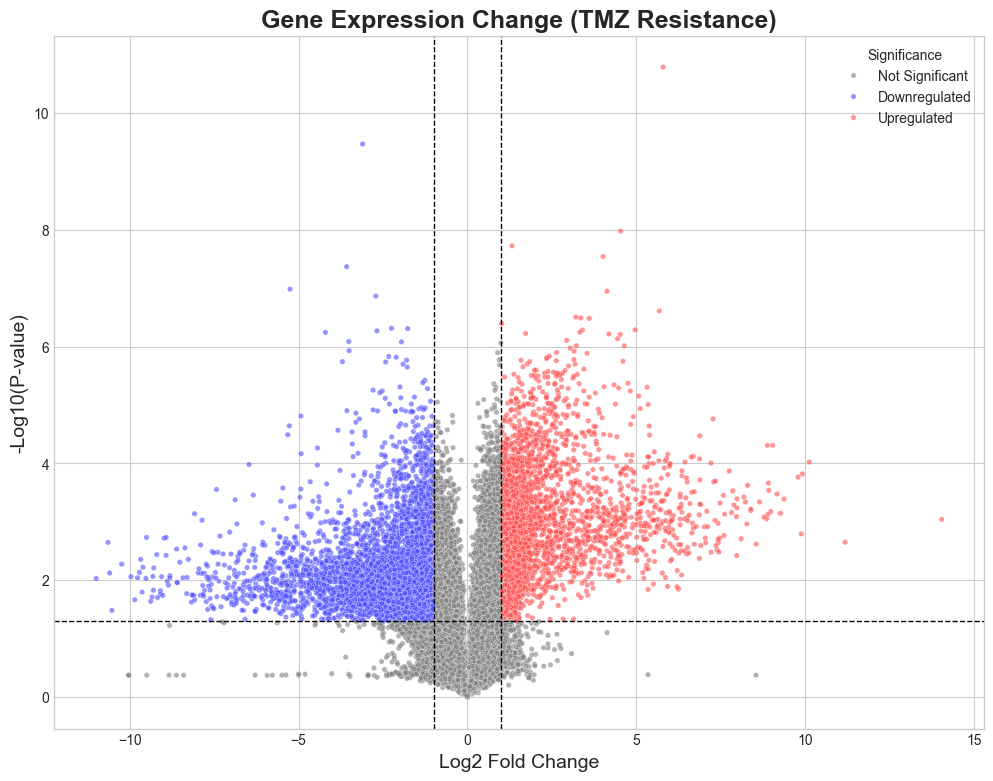

✅ Top 10 upregulated genes table saved as 'top_10_upregulated_tmz.png'.
✅ Top 10 downregulated genes table saved as 'top_10_downregulated_tmz.png'.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("--- Creating Final, Well-Formatted Figures for the TMZ Dataset ---")

try:
    # --- 1. Create and Save the Volcano Plot (No changes here) ---
    filtered_df_new['-log10_p_value'] = -np.log10(filtered_df_new['p_value'].fillna(1))

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 9))
    sns.scatterplot(
        data=filtered_df_new, x='log2FoldChange', y='-log10_p_value', hue='significance',
        palette={'Upregulated': '#ff4d4d', 'Downregulated': '#4d4dff', 'Not Significant': 'grey'},
        alpha=0.6, s=15
    )
    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=1)
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=-1, color='black', linestyle='--', linewidth=1)
    plt.title('Gene Expression Change (TMZ Resistance)', fontsize=18, weight='bold')
    plt.xlabel('Log2 Fold Change', fontsize=14)
    plt.ylabel('-Log10(P-value)', fontsize=14)
    plt.legend(title='Significance')
    plt.savefig('volcano_plot_tmz.png', dpi=300, bbox_inches='tight')
    print("✅ New volcano plot saved as 'volcano_plot_tmz.png'.")
    plt.show()


    # --- 2. Create Nicely Formatted Table Images ---
    
    # Create a copy of the results to modify for plotting
    df_for_plotting = filtered_df_new.copy()

    # **THE FIX:** Shorten the long column names for better display
    df_for_plotting.rename(columns={
        'Control_Avg': 'Ctrl_Avg',
        'Resistant_Avg': 'Res_Avg',
        'log2FoldChange': 'Log2FC',
        'significance': 'Sig.'
    }, inplace=True)
    
    # --- Upregulated Table ---
    top_10_up_tmz = df_for_plotting.sort_values(by='Log2FC', ascending=False).head(10).round(2)
    fig_up, ax_up = plt.subplots(figsize=(14, 3.5)) # Slightly wider figure
    ax_up.axis('tight'); ax_up.axis('off')
    table_up = ax_up.table(cellText=top_10_up_tmz.values, colLabels=top_10_up_tmz.columns, loc='center', cellLoc='center')
    table_up.auto_set_font_size(False); table_up.set_fontsize(9); table_up.scale(1.1, 1.3) # Adjusted font and scale
    plt.savefig('top_10_upregulated_tmz.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    print("✅ Top 10 upregulated genes table saved as 'top_10_upregulated_tmz.png'.")
    plt.close(fig_up)

    # --- Downregulated Table ---
    top_10_down_tmz = df_for_plotting.sort_values(by='Log2FC', ascending=True).head(10).round(2)
    fig_down, ax_down = plt.subplots(figsize=(14, 3.5)) # Slightly wider figure
    ax_down.axis('tight'); ax_down.axis('off')
    table_down = ax_down.table(cellText=top_10_down_tmz.values, colLabels=top_10_down_tmz.columns, loc='center', cellLoc='center')
    table_down.auto_set_font_size(False); table_down.set_fontsize(9); table_down.scale(1.1, 1.3) # Adjusted font and scale
    plt.savefig('top_10_downregulated_tmz.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    print("✅ Top 10 downregulated genes table saved as 'top_10_downregulated_tmz.png'.")
    plt.close(fig_down)

except NameError:
    print("\nError: 'filtered_df_new' not found. Please re-run the analysis for the new dataset first.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("--- Creating Final, Well-Formatted Figures for the TMZ Dataset ---")

try:
    # --- Volcano Plot (No changes needed here) ---
    # You can re-run this part if you like, but it's not necessary for the table fix.
    # ... (volcano plot code remains the same) ...


    # --- Create Nicely Formatted Table Images ---
    
    # Create a copy of the results to modify for plotting
    df_for_plotting = filtered_df_new.copy()

    # Shorten the long column names
    df_for_plotting.rename(columns={
        'Control_Avg': 'Ctrl_Avg',
        'Resistant_Avg': 'Res_Avg',
        'log2FoldChange': 'Log2FC',
        'significance': 'Sig.'
    }, inplace=True)
    
    # --- Upregulated Table ---
    top_10_up_tmz = df_for_plotting.sort_values(by='Log2FC', ascending=False).head(10).round(2)
    
    # **THE FIX:** Increased figure width (16 instead of 14) and slightly smaller font (8.5)
    fig_up, ax_up = plt.subplots(figsize=(16, 3)) 
    ax_up.axis('tight'); ax_up.axis('off')
    table_up = ax_up.table(cellText=top_10_up_tmz.values, colLabels=top_10_up_tmz.columns, loc='center', cellLoc='center')
    table_up.auto_set_font_size(False); table_up.set_fontsize(8.5); table_up.scale(1.2, 1.2)
    plt.savefig('top_10_upregulated_tmz.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    print("✅ Top 10 upregulated genes table saved as 'top_10_upregulated_tmz.png'.")
    plt.close(fig_up)

    # --- Downregulated Table ---
    top_10_down_tmz = df_for_plotting.sort_values(by='Log2FC', ascending=True).head(10).round(2)

    # **THE FIX:** Applied the same formatting adjustments here
    fig_down, ax_down = plt.subplots(figsize=(16, 3))
    ax_down.axis('tight'); ax_down.axis('off')
    table_down = ax_down.table(cellText=top_10_down_tmz.values, colLabels=top_10_down_tmz.columns, loc='center', cellLoc='center')
    table_down.auto_set_font_size(False); table_down.set_fontsize(8.5); table_down.scale(1.2, 1.2)
    plt.savefig('top_10_downregulated_tmz.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
    print("✅ Top 10 downregulated genes table saved as 'top_10_downregulated_tmz.png'.")
    plt.close(fig_down)

except NameError:
    print("\nError: 'filtered_df_new' not found. Please re-run the analysis for the new dataset first.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")

--- Creating Final, Well-Formatted Figures for the TMZ Dataset ---
✅ Top 10 upregulated genes table saved as 'top_10_upregulated_tmz.png'.
✅ Top 10 downregulated genes table saved as 'top_10_downregulated_tmz.png'.


In [12]:
# This assumes 'filtered_df' and 'filtered_df_new' are in memory.

try:
    # --- Olaparib Study Tables ---
    top_10_up_olaparib = filtered_df.sort_values(by='log2FoldChange', ascending=False).head(10)
    top_10_down_olaparib = filtered_df.sort_values(by='log2FoldChange', ascending=True).head(10)

    # --- TMZ Study Tables ---
    top_10_up_tmz = filtered_df_new.sort_values(by='log2FoldChange', ascending=False).head(10)
    top_10_down_tmz = filtered_df_new.sort_values(by='log2FoldChange', ascending=True).head(10)
    
    # --- Convert to Text and Print ---
    print("\n--- Top 10 Upregulated Genes (Olaparib) ---")
    print(top_10_up_olaparib.to_string())
    
    print("\n\n--- Top 10 Downregulated Genes (Olaparib) ---")
    print(top_10_down_olaparib.to_string())

    print("\n\n--- Top 10 Upregulated Genes (TMZ) ---")
    print(top_10_up_tmz.to_string())
    
    print("\n\n--- Top 10 Downregulated Genes (TMZ) ---")
    print(top_10_down_tmz.to_string())

except NameError:
    print("\nError: A DataFrame was not found. Please re-run your analysis cells to create 'filtered_df' and 'filtered_df_new'.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


--- Top 10 Upregulated Genes (Olaparib) ---
            GeneSymbol  T1.FPKM  T2.FPKM     TO1.FPKM     TO2.FPKM  Control_Avg_FPKM  Resistant_Avg_FPKM   p_value  log2FoldChange     significance
15190  ENSG00000167941     0.00     4.00   237.000000   380.000000             2.000          308.500000  0.145659        6.688833  Not Significant
8      ENSG00000123983     3.81     3.89   474.900087   451.155083             3.850          463.027585  0.016456        6.580082      Upregulated
22991  ENSG00000204889     0.00     0.00    49.000000   116.000000             0.000           82.500000  0.245557        6.383704  Not Significant
13814  ENSG00000162891     0.00     0.00    50.000000    90.000000             0.000           70.000000  0.177171        6.149747  Not Significant
0      ENSG00000105835    61.18    49.11  3906.822354  3711.481237            55.145         3809.151795  0.016160        6.084547      Upregulated
3321   ENSG00000015413     0.00     0.00    69.000000    53.000000 

In [13]:
import pandas as pd

# This assumes 'filtered_df' and 'filtered_df_new' are in memory.

try:
    # --- Create the Top 10 DataFrames ---
    top_10_up_olaparib = filtered_df.sort_values(by='log2FoldChange', ascending=False).head(10)
    top_10_down_olaparib = filtered_df.sort_values(by='log2FoldChange', ascending=True).head(10)
    top_10_up_tmz = filtered_df_new.sort_values(by='log2FoldChange', ascending=False).head(10)
    top_10_down_tmz = filtered_df_new.sort_values(by='log2FoldChange', ascending=True).head(10)
    
    # --- Format and Print Each DataFrame ---

    # Set display options to round numbers and give more width
    pd.set_option('display.precision', 4)
    pd.set_option('display.width', 1000)

    print("\n--- Top 10 Upregulated Genes (Olaparib Study) ---")
    # Rename columns for display
    top_10_up_olaparib.rename(columns={'Control_Avg_FPKM': 'Ctrl_Avg', 'Resistant_Avg_FPKM': 'Res_Avg'}, inplace=True)
    print(top_10_up_olaparib.to_string())
    
    print("\n\n--- Top 10 Downregulated Genes (Olaparib Study) ---")
    top_10_down_olaparib.rename(columns={'Control_Avg_FPKM': 'Ctrl_Avg', 'Resistant_Avg_FPKM': 'Res_Avg'}, inplace=True)
    print(top_10_down_olaparib.to_string())

    print("\n\n--- Top 10 Upregulated Genes (TMZ Study) ---")
    top_10_up_tmz.rename(columns={'Control_Avg': 'Ctrl_Avg', 'Resistant_Avg': 'Res_Avg'}, inplace=True)
    print(top_10_up_tmz.to_string())
    
    print("\n\n--- Top 10 Downregulated Genes (TMZ Study) ---")
    top_10_down_tmz.rename(columns={'Control_Avg': 'Ctrl_Avg', 'Resistant_Avg': 'Res_Avg'}, inplace=True)
    print(top_10_down_tmz.to_string())

except NameError:
    print("\nError: A DataFrame was not found. Please re-run your analysis cells first.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


--- Top 10 Upregulated Genes (Olaparib Study) ---
            GeneSymbol  T1.FPKM  T2.FPKM   TO1.FPKM   TO2.FPKM  Ctrl_Avg    Res_Avg  p_value  log2FoldChange     significance
15190  ENSG00000167941     0.00     4.00   237.0000   380.0000     2.000   308.5000   0.1457          6.6888  Not Significant
8      ENSG00000123983     3.81     3.89   474.9001   451.1551     3.850   463.0276   0.0165          6.5801      Upregulated
22991  ENSG00000204889     0.00     0.00    49.0000   116.0000     0.000    82.5000   0.2456          6.3837  Not Significant
13814  ENSG00000162891     0.00     0.00    50.0000    90.0000     0.000    70.0000   0.1772          6.1497  Not Significant
0      ENSG00000105835    61.18    49.11  3906.8224  3711.4812    55.145  3809.1518   0.0162          6.0845      Upregulated
3321   ENSG00000015413     0.00     0.00    69.0000    53.0000     0.000    61.0000   0.0830          5.9542  Not Significant
7963   ENSG00000120057     3.00     2.00    98.0000   136.0000     